In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df=pd.read_csv('DNI_hr.csv')
df = df[["Date","Direct Normal [W/m^2]"]]
df["Date"] = pd.to_datetime(df["Date"])
df.set_index('Date', inplace=True)
df

,Direct Normal [W/m^2]
Date,
2008-06-01 00:00:00,0.000000
2008-06-01 01:00:00,0.000000
2008-06-01 02:00:00,0.000000
2008-06-01 03:00:00,0.000000
2008-06-01 04:00:00,12.084972
...,...
2013-12-31 19:00:00,0.000000
2013-12-31 20:00:00,0.000000
2013-12-31 21:00:00,0.000000


In [52]:
from datetime import timedelta
train_end = datetime(2013,12,30, 23, 0)
test_end = datetime(2013,12,31,23,0)
train_data = df[:train_end]
test_data = df[train_end + timedelta(hours=1):test_end]

In [49]:
from typing import Union

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [50]:
ps = range(0, 3, 1)
qs = range(0, 3, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))


d = 0
D = 0
s = 24

SARIMA_result_df = optimize_SARIMA(train_data, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(0, 0, 2, 2)",10.000000
1,"(0, 2, 1, 1)",713.936288
2,"(2, 2, 1, 2)",620483.869399
3,"(1, 1, 1, 2)",620499.922804
4,"(1, 2, 2, 1)",620500.629198
...,...,...
71,"(0, 1, 0, 0)",686790.385895
72,"(0, 0, 1, 0)",691197.584643
73,"(0, 0, 0, 2)",703472.411903
74,"(0, 0, 0, 1)",712085.718752


In [7]:
SARIMA_model = SARIMAX(train_data['Direct Normal [W/m^2]'], order=(0,0,2), seasonal_order=(1,0,1,24), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                Direct Normal [W/m^2]   No. Observations:                48936
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 24)   Log Likelihood                -351.968
Date:                              Wed, 31 Jul 2024   AIC                            713.936
Time:                                      18:19:25   BIC                            757.928
Sample:                                  06-01-2008   HQIC                           727.730
                                       - 12-30-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0002    3.5e-06    -52.840      0.000      -0.000      -0.000
ma.L2         -0.99

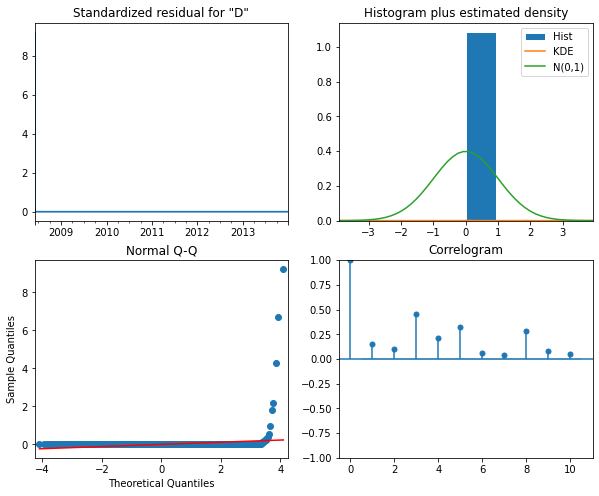

In [8]:
SARIMA_model_fit.plot_diagnostics(figsize=(10, 8));

In [9]:
SARIMA_model1 = SARIMAX(train_data['Direct Normal [W/m^2]'], order=(2,0,2), seasonal_order=(1,0,2,24), simple_differencing=False)
SARIMA_model1_fit = SARIMA_model1.fit(disp=False)

print(SARIMA_model1_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:              Direct Normal [W/m^2]   No. Observations:                48936
Model:             SARIMAX(2, 0, 2)x(1, 0, 2, 24)   Log Likelihood             -310233.935
Date:                            Wed, 31 Jul 2024   AIC                         620483.869
Time:                                    18:33:21   BIC                         620554.256
Sample:                                06-01-2008   HQIC                        620505.940
                                     - 12-30-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7161      0.016    105.717      0.000       1.684       1.748
ar.L2         -0.7225      0.013   

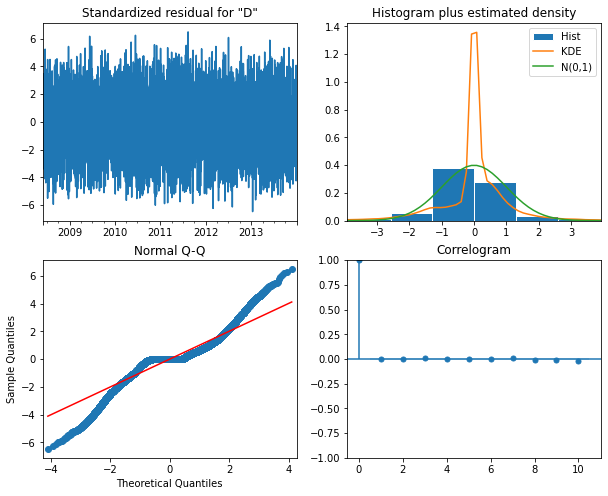

In [10]:
SARIMA_model1_fit.plot_diagnostics(figsize=(10, 8));

In [25]:
SARIMA_pred = SARIMA_model1_fit.forecast(len(test_data))
predictions = pd.Series(SARIMA_pred, index=test_data.index)
residuals = test_data['Direct Normal [W/m^2]'] - predictions
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 148.3679408505223


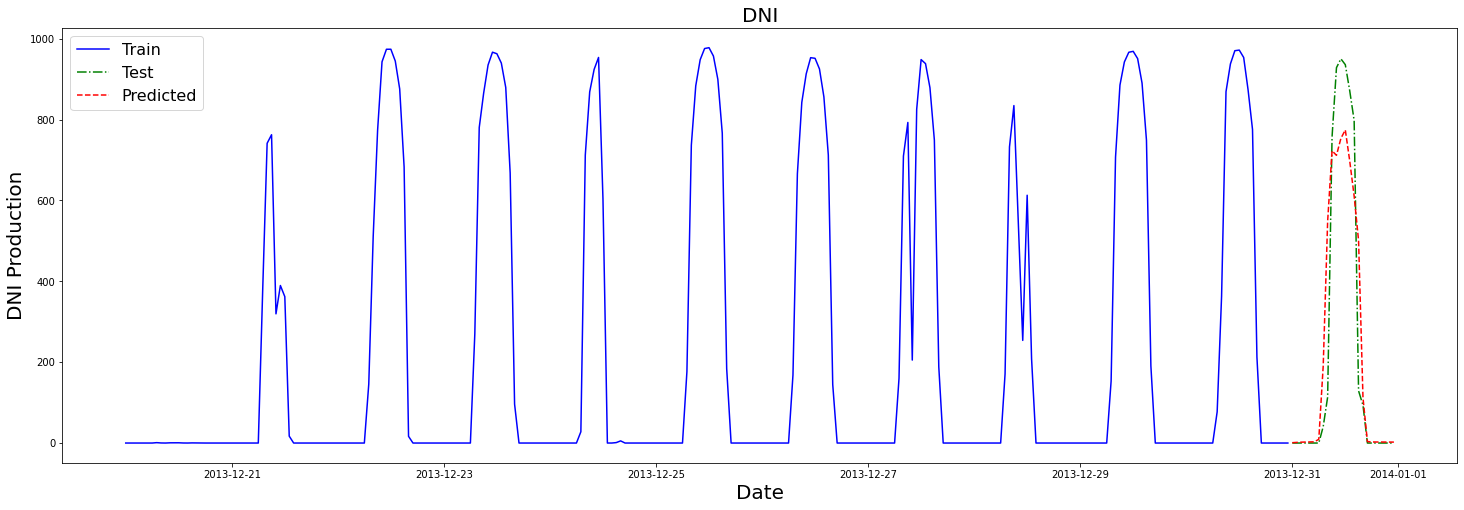

In [27]:
#plot prediction
start_date = datetime(2013,12,20)
end_date = datetime(2013,12,30, 23, 0)
lim_train_data = train_data[start_date:end_date]

plt.figure(figsize=(25,8))

plt.plot(lim_train_data,'b-', label='Train')
plt.plot(test_data['Direct Normal [W/m^2]'],'g-.', label='Test')
plt.plot(predictions, 'r--', label='Predicted')
plt.legend(loc=2,fontsize=16)

plt.title('DNI', fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylabel('DNI Production', fontsize=20)
plt.show()

In [44]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    
    pred_SARIMA = []

    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=(2,0,2), seasonal_order=(1,0,2,24), simple_differencing=False)
        model_fit = model.fit(disp=False)
        predictions = model_fit.get_prediction(0, i + window - 1)
        rol_pred = predictions.predicted_mean.iloc[-window:]
        pred_SARIMA.extend(rol_pred)

    return pred_SARIMA

In [54]:
train_len= len(train_data)
horizon = len(test_data)
window = 2


pred_SARIMA = rolling_forecast(df, train_len, horizon,window)

In [55]:
predictions = pd.Series(pred_SARIMA, index=test_data.index)
residuals = test_data['Direct Normal [W/m^2]'] - predictions
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 156.63387382093322


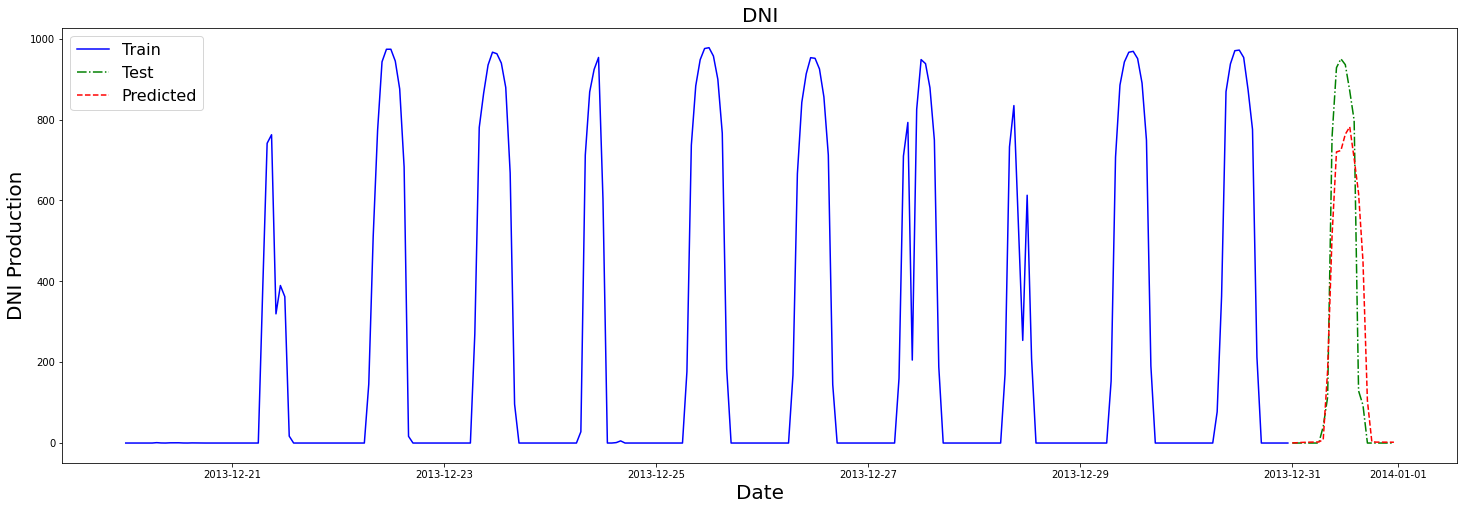

In [53]:
#plot prediction
start_date = datetime(2013,12,20)
end_date = datetime(2013,12,30, 23, 0)
lim_train_data = train_data[start_date:end_date]

plt.figure(figsize=(25,8))

plt.plot(lim_train_data,'b-', label='Train')
plt.plot(test_data['Direct Normal [W/m^2]'],'g-.', label='Test')
plt.plot(predictions, 'r--', label='Predicted')
plt.legend(loc=2,fontsize=16)

plt.title('DNI', fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylabel('DNI Production', fontsize=20)
plt.show()

# Long term forecast

In [62]:
from datetime import timedelta
train_end = datetime(2013,12,24, 23, 0)
test_end = datetime(2013,12,31,23,0)
train_data = df[:train_end]
test_data = df[train_end + timedelta(hours=1):test_end]

In [63]:
SARIMA_model1 = SARIMAX(train_data['Direct Normal [W/m^2]'], order=(2,0,2), seasonal_order=(1,0,2,24), simple_differencing=False)
SARIMA_model1_fit = SARIMA_model1.fit(disp=False)

print(SARIMA_model1_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:              Direct Normal [W/m^2]   No. Observations:                48792
Model:             SARIMAX(2, 0, 2)x(1, 0, 2, 24)   Log Likelihood             -309350.707
Date:                            Fri, 02 Aug 2024   AIC                         618717.414
Time:                                    23:06:44   BIC                         618787.776
Sample:                                06-01-2008   HQIC                        618739.479
                                     - 12-24-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7176      0.007    247.717      0.000       1.704       1.731
ar.L2         -0.7228      0.005   

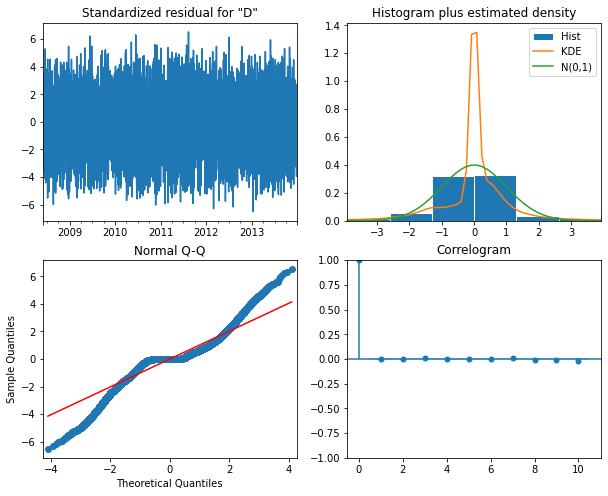

In [64]:
SARIMA_model1_fit.plot_diagnostics(figsize=(10, 8));

In [65]:
SARIMA_pred = SARIMA_model1_fit.forecast(len(test_data))
predictions = pd.Series(SARIMA_pred, index=test_data.index)
residuals = test_data['Direct Normal [W/m^2]'] - predictions
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 169.19440580948893


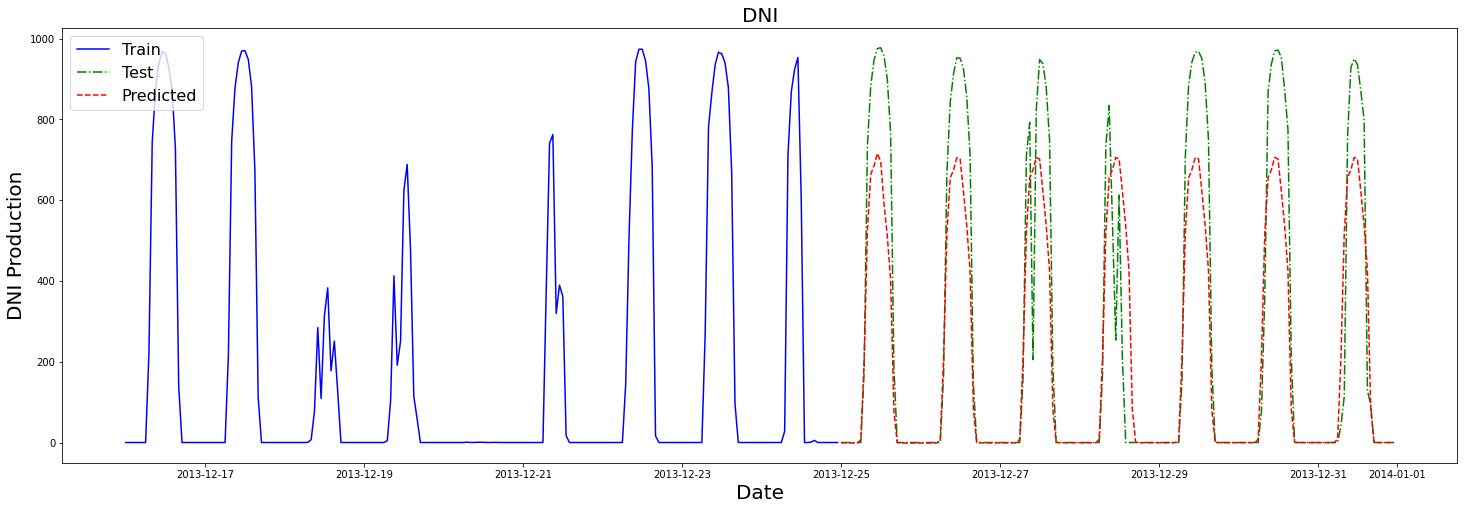

In [66]:
#plot prediction
start_date = datetime(2013,12,16)
end_date = datetime(2013,12,24, 23, 0)
lim_train_data = train_data[start_date:end_date]

plt.figure(figsize=(25,8))

plt.plot(lim_train_data,'b-', label='Train')
plt.plot(test_data['Direct Normal [W/m^2]'],'g-.', label='Test')
plt.plot(predictions, 'r--', label='Predicted')
plt.legend(loc=2,fontsize=16)

plt.title('DNI', fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylabel('DNI Production', fontsize=20)
plt.show()

In [70]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    
    pred_SARIMA = []

    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=(1,0,1), seasonal_order=(1,0,1,24), simple_differencing=False)
        model_fit = model.fit(disp=False)
        predictions = model_fit.get_prediction(0, i + window - 1)
        rol_pred = predictions.predicted_mean.iloc[-window:]
        pred_SARIMA.extend(rol_pred)

    return pred_SARIMA

In [71]:
train_len= len(train_data)
horizon = len(test_data)
window = 2


pred_SARIMA = rolling_forecast(df, train_len, horizon,window)

In [72]:
predictions = pd.Series(pred_SARIMA, index=test_data.index)
residuals = test_data['Direct Normal [W/m^2]'] - predictions
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 126.3694078382671


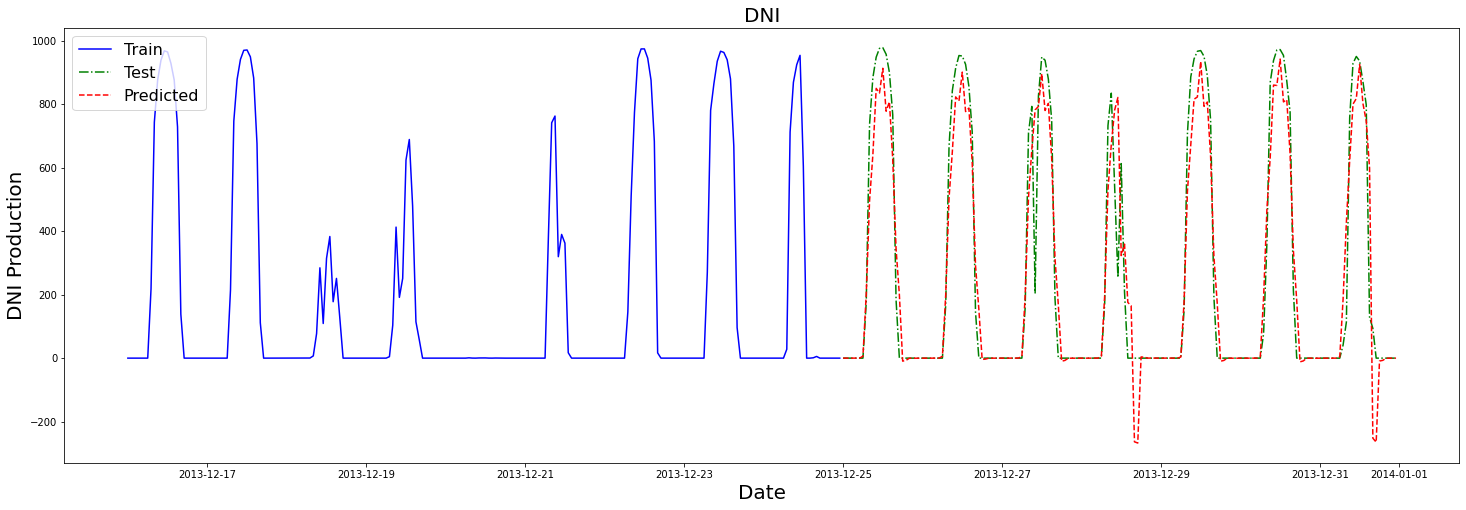

In [73]:
#plot prediction
start_date = datetime(2013,12,16)
end_date = datetime(2013,12,24, 23, 0)
lim_train_data = train_data[start_date:end_date]

plt.figure(figsize=(25,8))

plt.plot(lim_train_data,'b-', label='Train')
plt.plot(test_data['Direct Normal [W/m^2]'],'g-.', label='Test')
plt.plot(predictions, 'r--', label='Predicted')
plt.legend(loc=2,fontsize=16)

plt.title('DNI', fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylabel('DNI Production', fontsize=20)
plt.show()